# CodeNet Dataset

In this notebook I intend to make it very easy to visualize all the necessary information about a specific problem. The base dataset I will be using in this notebook is [CodeNet](https://github.com/IBM/Project_CodeNet) which is a large collection of source files and problem descriptions with metadata. The solutions are written in multiple programming languages (55+ according to the paper) and each problem has multiple submissions. Most of the submissions are written in the six most common languages (C++, Python, Java, C, Ruby, C#). As expected most of the solutions are in C++. One interesting aspect of the dataset is that it includes failed submissions, with various status codes such as Compilation Errors, Runtime Errors, Time Limit Exceeded, Memory Limit Exceeded, etc. This will prove useful since we are looking into bug detection in source code files.

# Table of Contents
1. [Download CodeNet](#Download-CodeNet)
2. [Explore CodeNet](#Explore-CodeNet)
3. [Explore Problem 0](#Explore-Problem-0)
4. [Missing Values](#Missing-Values)
5. [Explore Other Problems](#Explore-Other-Problems)
6. [Generate Source Code Pairs](#Generate-Source-Code-Pairs)
7. [Analyze source code files](#Analyze-source-code-files)

In [1]:
import os
import re
import io
import sys
import wget
import html
import pickle
import random
import tarfile
import itertools
import functools
import subprocess

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import more_itertools as more_itertools

from bs4 import BeautifulSoup
from IPython.display import display, HTML
from tqdm import tqdm
from pprint import pprint
from difflib import Differ, SequenceMatcher
from collections import Counter

tqdm.pandas()

# Initialize the dataset paths
input_path = '../input/'
root_path = input_path + 'Project_CodeNet/'

tools_path = '../Project_CodeNet/tools/'
tokenizer_path = tools_path + 'tokenizer/tokenize'

assert os.path.exists(tokenizer_path), 'You first need to compile the tokenier utility'

os.makedirs(input_path, exist_ok=True)

data_path = root_path + 'data/'
metadata_path = root_path + 'metadata/'
derived_path = root_path + 'derived/'
descriptions_path = root_path + 'problem_descriptions/'

def id2desc(problem_id): return descriptions_path + problem_id + '.html'
def id2inout(problem_id, name='input'): 
    return derived_path + 'input_output/data/' + problem_id + '/' + name + '.txt'
def id2submission(problem_id, language, submission_id, filename_ext): 
    return data_path + problem_id + '/' + language + '/' + submission_id + '.' + filename_ext

## Download CodeNet

The next code cell will download the CodeNet dataset from it's original repository (the archive has around 80GB). If you already have the dataset change the input_path variable to point to the root of the dataset, otherwise the notebook will download it in the ../input/ directory.

In [2]:
data_url = "https://dax-cdn.cdn.appdomain.cloud/dax-project-codenet/1.0.0"
tar_name = "Project_CodeNet.tar.gz"
tar_path = input_path + tar_name

def download_data():
    if os.path.exists(root_path):
        print("dataset root dir found")
        return

    if not os.path.exists(tar_path):
        wget.download(f"{data_url}/{tar_name}", out=tar_path)
        
    with tarfile.open(tar_path) as tf:
        tf.extractall(path=data_path)

download_data()

dataset root dir found


## Explore CodeNet

The dataset contains a metadata folder with details for each problem, which is basically a list of submissions with status codes, user IDs, time and memory consumption, and the programming language used for that solution. Other than that, the metadata contains a csv file with a list of all the problems, with some basic information, such as the name.

Let's load the problem list table and look at the data. We are interested in seeing how many problems we have and from what coding competition each problem is taken from.

In [3]:
# Load the problem list table as a csv
problem_list_df = pd.read_csv(metadata_path + 'problem_list.csv')
problem_list_df.set_index('id', inplace=True)

print(f"We have {len(problem_list_df)} problems")
print('The distribution of the datasets is')
print(problem_list_df['dataset'].value_counts(normalize=True))
display(problem_list_df.head())
display(problem_list_df.isna().sum())

We have 4053 problems
The distribution of the datasets is
AIZU       0.625216
AtCoder    0.374784
Name: dataset, dtype: float64


,name,dataset,time_limit,memory_limit,rating,tags,complexity
id,,,,,,,
p00000,QQ,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00001,List of Top 3 Hills,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00002,Digit Number,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00003,Is it a Right Triangle?,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00004,Simultaneous Equation,AIZU,1000.0,131072.0,NaN,NaN,NaN


name              56
dataset            0
time_limit        56
memory_limit      56
rating          4053
tags            4053
complexity      4053
dtype: int64

We can see that we have around 4000 problems with 2 thirds coming from the AIZU dataset and the rest from the AtCoder dataset. Another interesting aspect is that the rating, tags and complexity is missing for all the problems. The tags could have beed useful to classify the problem into corresponding categories, such as graph problem or dynamic programing problem, etc. There are also some data missing for the name, time limit and memory limit for a few problems, but it shouldn't be a problem. We can fill in the missing values for time limit and memory limit with some arbitrary numbers, such as the median values for those columns. I think that the name is not that relevant so we can skip it. Maybe the missing name hints toward the fact that we have some missing description files in the dataset.

In [4]:
print('Median value for the time limit ', problem_list_df['time_limit'].median())
print('Median value for the memory limit ', problem_list_df['memory_limit'].median())

Median value for the time limit  2000.0
Median value for the memory limit  262144.0


In [5]:
problem_list_df['time_limit'].fillna(problem_list_df['time_limit'].median(), inplace=True)
problem_list_df['memory_limit'].fillna(problem_list_df['memory_limit'].median(), inplace=True)
display(problem_list_df.isna().sum())

name              56
dataset            0
time_limit         0
memory_limit       0
rating          4053
tags            4053
complexity      4053
dtype: int64

## Explore Problem 0

Let's look for example at the first problem and see how many submissions it has, what programming languages were used, what was the distribution of the status for the submissions and the users that attempted this problem. Let's also see what was the average number of submissions per user.

In [6]:
problem_id = 'p00000'

problem_df = pd.read_csv(metadata_path + f'{problem_id}.csv')
problem_df.set_index('submission_id', inplace=True)

print(f"We have {len(problem_df)} submissions for problem {problem_id}")
print('The distribution of the programming languages is')
print(problem_df['language'].value_counts())
print('The distribution of the status is')
print(problem_df['status'].value_counts())
print('The number of users that attempted this problem', len(problem_df['user_id'].unique()))
print('The average number of submissions of a user', problem_df.groupby('user_id').size().mean())
print('The min number of submissions of a user', problem_df.groupby('user_id').size().min())
print('The median number of submissions of a user', problem_df.groupby('user_id').size().median())
print('The max number of submissions of a user', problem_df.groupby('user_id').size().max())
display(problem_df.head())

We have 16099 submissions for problem p00000
The distribution of the programming languages is
C++           5231
C             4849
Java          2291
Python        1626
Ruby           701
C#             416
PHP            316
JavaScript     288
Scala          105
Haskell        103
D               89
Go              31
Rust            24
OCaml           22
Kotlin           7
Name: language, dtype: int64
The distribution of the status is
Accepted                  8597
Wrong Answer              3187
Compile Error             2638
Runtime Error              952
WA: Presentation Error     545
Time Limit Exceeded        164
Memory Limit Exceeded       13
Output Limit Exceeded        3
Name: status, dtype: int64
The number of users that attempted this problem 5944
The average number of submissions of a user 2.708445491251682
The min number of submissions of a user 1
The median number of submissions of a user 1.0
The max number of submissions of a user 1362


,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
submission_id,,,,,,,,,,,
s694813024,p00000,u706566315,1540908251,Rust,Rust,rs,Wrong Answer,0,5012,120,0/1
s554950692,p00000,u706566315,1540908314,Rust,Rust,rs,Accepted,0,5004,124,1/1
s555203498,p00000,u759934006,1513417513,Rust,Rust,rs,Accepted,0,5020,136,1/1
s309783173,p00000,u233505136,1516826051,Rust,Rust,rs,Accepted,0,5004,123,1/1
s184977351,p00000,u191088660,1517740150,Rust,Rust,rs,Accepted,0,5004,122,1/1


We can see that for this problem the top six used programming languages matches the top six of the entire dataset (C++, C, Java, Python, Ruby, C#) and also that the distribution of the status is again consistent, with around 50% accepted submissions and the rest being some form of error, according to the dataset paper. It looks like the number of users that tried this problem is very large, ~6000, the average number of submission being equal to 2.7, but in this case we can see that the average is not that useful, it being very sensitive to outliers, as there is an user that sent over 1000 submissions, so I think that the median is a better metric for trying to see how hard a problem was. In the case of the first problem the median number of submissions for a single user is 1, so we can assume that this problem was easy to solve. Now I think that C is a simple enough language so we can take a subsample of the first problem containing only the C solutions and continue from there.

In [7]:
languages = problem_df['language'].unique()
language = 'C'

problem_df = problem_df[problem_df['language'] == language]

print(f"We have {len(problem_df)} submissions for problem {problem_id}")
print('The distribution of the programming languages is')
print(problem_df['language'].value_counts())
print('The distribution of the status is')
print(problem_df['status'].value_counts())
print('The number of users that attempted this problem', len(problem_df['user_id'].unique()))
print('The average number of submissions of a user', problem_df.groupby('user_id').size().mean())
print('The min number of submissions of a user', problem_df.groupby('user_id').size().min())
print('The median number of submissions of a user', problem_df.groupby('user_id').size().median())
print('The max number of submissions of a user', problem_df.groupby('user_id').size().max())
display(problem_df.head())

We have 4849 submissions for problem p00000
The distribution of the programming languages is
C    4849
Name: language, dtype: int64
The distribution of the status is
Accepted                  2089
Wrong Answer              1126
Compile Error              993
Runtime Error              389
WA: Presentation Error     189
Time Limit Exceeded         61
Memory Limit Exceeded        2
Name: status, dtype: int64
The number of users that attempted this problem 1704
The average number of submissions of a user 2.845657276995305
The min number of submissions of a user 1
The median number of submissions of a user 1.0
The max number of submissions of a user 865


,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
submission_id,,,,,,,,,,,
s113530555,p00000,u564373483,1530931912,C,C,c,Accepted,0,2036,148,1/1
s650564374,p00000,u011621222,1530986413,C,C,c,Wrong Answer,0,2044,177,0/1
s054320558,p00000,u011621222,1530987028,C,C,c,Wrong Answer,0,2044,191,0/1
s104411660,p00000,u011621222,1531006441,C,C,c,Wrong Answer,0,2032,197,0/1
s966149516,p00000,u011621222,1531030321,C,C,c,Wrong Answer,0,1984,190,0/1


Again it looks like the distribution of the statistics is consistent with the entire dataset even for this subset. Now it would be interesting to see some examples of solutions found for this problem. Let's start by creating a function that reads a C submission from the dataset source files.

In [8]:
submission = problem_df[problem_df['status'] == 'Accepted'].index[0]

with open(id2submission('p00000', 'C', submission, 'c')) as f:
    text = f.readlines()
    
sys.stdout.writelines(text)

#include<stdio.h>

int main(){
  int i,j;

  for(i=1;i<10;i++){
    for(j=1;j<10;j++){
      printf("%dx%d=%d\n",i,j,i*j);
    }
  }

  return 0;
}


In [9]:
submission = problem_df[problem_df['status'] == 'Accepted'].index[1]

with open(id2submission('p00000', 'C', submission, 'c')) as f:
    text = f.readlines()
    
sys.stdout.writelines(text)

#include<stdio.h>
int main()
{
    int i,j;
    for(i=1; i<10; i++)
    {
        for(j=1; j<10; j++)
            printf("%dx%d=%d\n", i, j, (i*j));
    }

    return 0;
}



In [10]:
submission = problem_df[problem_df['status'] == 'Accepted'].index[2]

with open(id2submission('p00000', 'C', submission, 'c')) as f:
    text = f.readlines()
    
sys.stdout.writelines(text)

#include<stdio.h>
int main()
{
    int i,a,c;
    for(i=1; i<=9; i++)
    {
        for(a=1; a<=9; a++)
        {
            c=i*a;
            printf("%dx%d=%d\n",i,a,c);
        }
    }

}



So these solutions make me think that the problem consists only in implementing a printing function for multiplication rules. To make sure we can check the description file of the problem.

In [11]:
with open(id2desc('p00000')) as f:
    text = f.readlines()
display(HTML(''.join(text)))

## Missing Values

The dataset also includes a description file for most of the problems. We can see which problems have or don't have a description associated. The description file can be useful to predict what the problem topic is about, graphs, dp, greedy, etc.

In [12]:
problem_ids = problem_list_df.index.unique()

In [13]:
description_mask = [os.path.exists(id2desc(problem_id)) for problem_id in problem_ids]
description_mask_not = [not x for x in description_mask]

print(f'There are {len(problem_list_df[description_mask_not])} missing description files.')
print('Missing values for the problems without description')
display(problem_list_df[description_mask_not].isna().sum())
print('Missing values for the problems with description')
display(problem_list_df[description_mask].isna().sum())

There are 54 missing description files.
Missing values for the problems without description


name            54
dataset          0
time_limit       0
memory_limit     0
rating          54
tags            54
complexity      54
dtype: int64

Missing values for the problems with description


name               2
dataset            0
time_limit         0
memory_limit       0
rating          3999
tags            3999
complexity      3999
dtype: int64

All missing description files are linked to the missing name in the problem list csv.

In [14]:
x_df = problem_list_df[description_mask][problem_list_df[description_mask]['name'].isna()]

x_df

,name,dataset,time_limit,memory_limit,rating,tags,complexity
id,,,,,,,
p02478,NaN,AIZU,2000.0,262144.0,NaN,NaN,NaN
p02533,NaN,AIZU,2000.0,262144.0,NaN,NaN,NaN


In [15]:
print(f'=================={x_df.index[0]}=====================')
with open(id2desc(x_df.index[0])) as f:
    text = f.readlines()
display(HTML(''.join(text)))
print(f'Submissions for the {x_df.index[0]} problem ', len(pd.read_csv(metadata_path + f'{x_df.index[0]}.csv')))

print(f'================={x_df.index[1]}======================')
with open(id2desc(x_df.index[1])) as f:
    text = f.readlines()
display(HTML(''.join(text)))

print(f'Submissions for the {x_df.index[1]} problem ', len(pd.read_csv(metadata_path + f'{x_df.index[1]}.csv')))

==================p02478=====================


Submissions for the p02478 problem  0
=================p02533======================


Submissions for the p02533 problem  0


The first problem with a missing name with a description links to a 404 Page and the other one is a basic description file but looks like a test problem, with no submissions. In fact, none of those 2 problems have a single submission. So they are useless.

In [16]:
x_df = problem_list_df[description_mask_not][problem_list_df[description_mask_not]['name'].isna()]

x_df['dataset'].value_counts()

AIZU    54
Name: dataset, dtype: int64

In [17]:
print('Number of submissions for problems without a description file')
for i in range(len(x_df)):
    print(f'Submissions for the {x_df.index[i]} problem ', len(pd.read_csv(metadata_path + f'{x_df.index[i]}.csv')))

Number of submissions for problems without a description file
Submissions for the p02479 problem  4052
Submissions for the p02480 problem  4277
Submissions for the p02481 problem  3577
Submissions for the p02482 problem  4194
Submissions for the p02483 problem  3905
Submissions for the p02484 problem  2826
Submissions for the p02485 problem  1698
Submissions for the p02486 problem  1795
Submissions for the p02487 problem  2057
Submissions for the p02488 problem  1492
Submissions for the p02489 problem  3817
Submissions for the p02490 problem  2827
Submissions for the p02491 problem  3143
Submissions for the p02492 problem  2076
Submissions for the p02493 problem  2743
Submissions for the p02494 problem  3362
Submissions for the p02495 problem  2190
Submissions for the p02496 problem  1921
Submissions for the p02497 problem  2539
Submissions for the p02498 problem  1512
Submissions for the p02499 problem  2643
Submissions for the p02500 problem  6
Submissions for the p02501 problem  11


Now let's look at missing input files. Do they match with the missing description or are they more? Or are some problems not expected to use input, such as the first problem that was just a print problem.

In [18]:
input_mask = [os.path.exists(id2inout(problem_id)) for problem_id in problem_ids]
input_mask_not = [not x for x in input_mask]

print(f'There are {len(problem_list_df[input_mask_not])} missing input files.')
print('Missing values for the problems without input')
display(problem_list_df[input_mask_not].isna().sum())
print('Missing values for the problems with input')
display(problem_list_df[input_mask].isna().sum())

There are 186 missing input files.
Missing values for the problems without input


name             56
dataset           0
time_limit        0
memory_limit      0
rating          186
tags            186
complexity      186
dtype: int64

Missing values for the problems with input


name               0
dataset            0
time_limit         0
memory_limit       0
rating          3867
tags            3867
complexity      3867
dtype: int64

Looks like there are more problems without input/output rather than just missing descriptions. But again the problems that are missing the descriptions are also missing the input. In this case it is better to just drop those problems, since we cannot for sure tell how to run them.

In [19]:
description_and_not_input_mask = [x and y for (x, y) in zip(input_mask_not, description_mask)]

x_df = problem_list_df[description_and_not_input_mask]
x_df.isna().sum()

name              2
dataset           0
time_limit        0
memory_limit      0
rating          132
tags            132
complexity      132
dtype: int64

In the case of missing input files, I think it is also better to just drop the submissions, most of the description files are written in Chinese and we cannot really extract any useful information from them. Since there are so few files with no input we can drop them. By looking in the description files there are like 2 problems with no input from the stdin.

To conclude the missing values section, 54/56 of the missing names in the problems list are due to missing description files 1/56 is just a href which links to a 404 web page and the last one is a test problem, the later 2 problems having no submissions anyway. I think it is a fair decision to drop these samples as they are not useful. There will be 130 remaining problems with no input/output samples and 128 of them have description files in Chinese which makes it harder to extract samples, and 2 of them only require printing of values (similar to problem p00000). In this case I also think that it is ok to drop those 2 problems that don't need input alongside the rest of problems that have no input examples extracted, because we don't have to remember that there is one or two problems that can cause some bugs later on.

In [20]:
problem_list_clean_path = input_path + 'problem_list_clean.csv'

In [21]:
# Since the problems with missing input include those with missing name we can just drop those
problem_list_df = problem_list_df[input_mask]
problem_ids = problem_list_df.index.unique()

print(f"We have {len(problem_list_df)} problems")
print('The distribution of the datasets is')
print(problem_list_df['dataset'].value_counts(normalize=True))
display(problem_list_df.head())
display(problem_list_df.isna().sum())
problem_list_df.to_csv(problem_list_clean_path)

We have 3867 problems
The distribution of the datasets is
AIZU       0.613654
AtCoder    0.386346
Name: dataset, dtype: float64


,name,dataset,time_limit,memory_limit,rating,tags,complexity
id,,,,,,,
p00001,List of Top 3 Hills,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00002,Digit Number,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00003,Is it a Right Triangle?,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00004,Simultaneous Equation,AIZU,1000.0,131072.0,NaN,NaN,NaN
p00005,GCD and LCM,AIZU,1000.0,131072.0,NaN,NaN,NaN


name               0
dataset            0
time_limit         0
memory_limit       0
rating          3867
tags            3867
complexity      3867
dtype: int64

## Explore Other Problems

Now that we managed to load source code files and some statistics about the problem, let's generalize it and make a function that can show statistics for any problem_id and print a number of samples with different status code.

In [22]:
def load_problem_csv(problem_id):
    problem_df = pd.read_csv(metadata_path + f'{problem_id}.csv')
    problem_df.set_index('submission_id', inplace=True)
    return problem_df

def pprint_problem(problem_df, problem_id=None):
    if problem_id is None:
        problem_id = problem_id['problem_id'][0]

    print(f"We have {len(problem_df)} submissions for problem {problem_id}")
    print('The distribution of the programming languages is')
    print(problem_df['language'].value_counts())
    print('The distribution of the status is')
    print(problem_df['status'].value_counts())
    print('The number of users that attempted this problem', len(problem_df['user_id'].unique()))
    print('The average number of submissions of a user', problem_df.groupby('user_id').size().mean())
    print('The min number of submissions of a user', problem_df.groupby('user_id').size().min())
    print('The median number of submissions of a user', problem_df.groupby('user_id').size().median())
    print('The max number of submissions of a user', problem_df.groupby('user_id').size().max())
    display(problem_df.head())
    
    with open(id2desc(problem_id)) as f:
        text = f.readlines()
    display(HTML(''.join(text)))
    
def pprint_submission(problem_df, problem_id, submission_id):
    language = problem_df.loc[submission_id, 'language']
    extension = problem_df.loc[submission_id, 'filename_ext']
    
    file_path = id2submission(problem_id, language, submission_id, extension)
    print(f"===================={submission_id}=======================")
    print('Showing source code for: ', file_path)
    print()
    with open(file_path) as f:
        submission_text = f.readlines()
    sys.stdout.writelines(submission_text)
    print()
    print("=====================================================")
    
def pprint_submissions(problem_df, problem_id, status='Accepted', count=1):
    submission_ids = random.sample(problem_df[problem_df['status'] == status].index.values.tolist(), count)
    
    for submission_id in submission_ids:
        pprint_submission(problem_df, problem_id, submission_id)

In [23]:
problem_ids = problem_list_df.index.unique()

In [24]:
problem_id = problem_ids[1]

problem_df = load_problem_csv(problem_id)
pprint_problem(problem_df, problem_id)

We have 11885 submissions for problem p00002
The distribution of the programming languages is
C++           4371
C             3501
Java          1342
Python        1226
Ruby           587
C#             365
JavaScript     166
Haskell         99
PHP             96
Scala           46
D               45
Go              16
OCaml           12
Rust            11
Kotlin           2
Name: language, dtype: int64
The distribution of the status is
Accepted                  4734
Wrong Answer              3863
Runtime Error             1377
Compile Error             1167
Time Limit Exceeded        702
WA: Presentation Error      36
Memory Limit Exceeded        6
Name: status, dtype: int64
The number of users that attempted this problem 3792
The average number of submissions of a user 3.134229957805907
The min number of submissions of a user 1
The median number of submissions of a user 2.0
The max number of submissions of a user 476


,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy
submission_id,,,,,,,,,,,
s459828833,p00002,u912124184,1531554169,Rust,Rust,rs,Accepted,0,5020,508,1/1
s754006783,p00002,u759934006,1513426109,Rust,Rust,rs,Accepted,0,5048,387,1/1
s834562369,p00002,u759934006,1513426789,Rust,Rust,rs,Accepted,0,5048,388,1/1
s801715135,p00002,u233505136,1516949032,Rust,Rust,rs,Accepted,0,5036,371,1/1
s298750993,p00002,u444102531,1518463316,Rust,Rust,rs,Compile Error,0,0,1907,0/1


In [25]:
pprint_submissions(problem_df, problem_id, status='Accepted', count=3)

====================s484278417=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/C/s484278417.c

#include <stdio.h>

int main(void)
{
    int a, b, sum, n;
    while (scanf("%d %d", &a, &b) == 2) {
        n = 0;
        sum = a + b;
        while (sum) {
            n++;
            sum /= 10;
        }
        printf("%d\n", n);
    }

    return 0;
}

====================s509742966=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/C++/s509742966.cpp

#include<iostream>
using namespace std;
int main(){
  int a,b;
  
  while(cin>>a>>b){
    a+=b;
    b=1;
    for(int i=1;i<=7;i++){
      b*=10;
      if(a<b){
	cout<<i<<endl;
	break;
      }
    }
  }
  return 0;
}
====================s080847012=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/C/s080847012.c

#include <stdio.h>
#include <string.h>

int main(void) {
    int a, b, len;
    char num[8];

    while (scanf("%d %d", &

In [26]:
pprint_submissions(problem_df, problem_id, status='Runtime Error', count=3)

====================s628661664=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/C#/s628661664.cs

using System;
using System.Linq;
namespace _0002
{
    class Program
    {
        static void Main(string[] args)
        {
            int a;
            int b = 1;
            string answer;
            while (true)
            {
                    int[] x = Console.ReadLine().Split().Select(int.Parse).ToArray();
                    a = x[0] + x[1];
                    answer = a.ToString();
                    b = answer.Length;
                    Console.WriteLine(b.ToString());
            }
        }
    }
}
====================s818492220=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/Java/s818492220.java

import java.util.*;

public class Main
{

	public static void main(String arg[])
	{
		Scanner sc = new Scanner(System.in);
		while(sc.hasNextLine())
		{
			String s = "";
			int x = sc.nextInt();
			int 

In [27]:
pprint_submissions(problem_df, problem_id, status='Wrong Answer', count=3)

====================s090420885=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/C++/s090420885.cpp

#include <stdio.h>
#include <math.h>
#include <iostream>
using namespace std;

int main(void){
	int a,b,dig;
	double sum,test;
	std::cin >> a >> b;
	sum = (double)a+(double)b;
	test = floor(log(sum)/log(9.99999999));
	std::cout << test+1 << "\n";
	return 0;
}
====================s727571177=======================
Showing source code for:  ../input/Project_CodeNet/data/p00002/C++/s727571177.cpp

#include<iostream>
using namespace std;
 
void digitLength()
{
    int a = 5;
    int b = 7;
    int len = 1;
    int div;
    
    int var = a+b;
    
    while(1)
    {
        div = var / 10;
        
        if(div == 0)
            break;
        var = div;
        len++;
        
    }
    
    cout<<len;
    return;
}
 
 
int main(){
 
    digitLength();
    return 0;
}
====================s349621399=======================
Showing source code for:  ../inp

In [28]:
counter = 0

user_ids = problem_df['user_id'].unique()
for user_id in user_ids:
    submission_df = problem_df[problem_df['user_id'] == user_id]
    
    if len(submission_df) < 2:
        continue
        
    counter += 1
    
print(f'Out of {len(user_ids)}, {counter} users have more than 1 submission')

Out of 3792, 2025 users have more than 1 submission


Even if this problem looked pretty easy, there are a lot of users that had more than 1 submission. This can be an indicator of how hard the problem is. For this task we can make use of the median number of submissions, for this problem it was 2.

## Generate Source Code Pairs
- for each problem:
- group solutions by user and select the solutions that are consecutive and of the form (Error, Accepted) with only one instruction (line) changed; heuristic to search a smaller space, since a user might submit a correct solution after a wrong one
- get the diff lines the diff operation (add, delete, change) and error type
- build a df from this list and save it
- sanity check: check that the error types of this df are the same as the types in the problem metadata: Success
- done

Up until this point we played around with single files and checked the looked at how we can load the source code from the dataset. In this section we will see how we can get the diff between source code files and more specifically the instruction (given by the line in the file) that caused a problem.

One interesting aspect here is how many users sent more than one submission and also have submissions of the form (failed, accepted) and have only one instruction changed so that we can understand what change made their code work. To do this we need to implement a function that calls the diff utility in the linux shell. Also to check if a diff output has only one instruction changed we need to implement a grouping function. One problem with this algorithm is that it is quite slow since it needs to execute diff from python, so as a solution we can use a function already implemented from the difflib library with some wrapper methods from github: https://github.com/glanois/code I changed something from this implementation though, which was causing the function to print the delimiters with new lines intercalated https://github.com/alexjercan/code.

In [29]:
class POSIXDiffer(Differ):
    """
    This class produces differences in the POSIX default format
    (see http://www.unix.com/man-page/POSIX/1posix/diff/),
    which is the same as the Gnu diff "normal format"
    (see http://www.gnu.org/software/diffutils/manual/diffutils.html#Normal).
    """

    def compare(self, a, b):
        cruncher = SequenceMatcher(self.linejunk, a, b)
        for tag, alo, ahi, blo, bhi in cruncher.get_opcodes():
            if alo == ahi:
                f1 = '%d' % alo
            elif alo+1 == ahi:
                f1 = '%d' % (alo+1)
            else:
                f1 = '%d,%d' % (alo+1, ahi)

            if blo == bhi:
                f2 = '%d' % blo
            elif blo+1 == bhi:
                f2 = '%d' % (blo+1)
            else:
                f2 = '%d,%d' % (blo+1, bhi)

            if tag == 'replace':
                g = itertools.chain([ '%sc%s\n' % (f1, f2) ], self._my_plain_replace(a, alo, ahi, b, blo, bhi))
            elif tag == 'delete':
                g = itertools.chain([ '%sd%s\n' % (f1, f2) ], self._dump('<', a, alo, ahi))
            elif tag == 'insert':
                g = itertools.chain([ '%sa%s\n' % (f1, f2) ], self._dump('>', b, blo, bhi))
            elif tag == 'equal':
                g = []
            else:
                raise(ValueError, 'unknown tag %r' % (tag,))

            for line in g:
                yield line

    def _my_plain_replace(self, a, alo, ahi, b, blo, bhi):
        assert alo < ahi and blo < bhi
        first  = self._dump('<', a, alo, ahi)
        second = self._dump('>', b, blo, bhi)

        for g in first, ['---\n'], second:
            for line in g:
                yield line

def pdiff(a, b):
    """
    Compare `a` and `b` (lists of strings); return a POSIX/Gnu "normal format" diff.
    """
    return POSIXDiffer().compare(a, b)

def group_diff_chunks(diff):
    """
    This function creates a list by extracting the start line, end line for
    the files in the diff that are of the form n[,n]cn[,n] (the output of the
    diff command in shell)
    """
    def normalize_chunk(chunk):
        s1, e1, op, s2, e2 = chunk

        s1 = int(s1)
        e1 = (s1 if not e1 else int(e1)) + 1
        s2 = int(s2)
        e2 = (s2 if not e2 else int(e2)) + 1

        return s1, e1, op, s2, e2

    p = re.compile(r'^([0-9]+),?([0-9]*)([a-zA-Z])([0-9]+),?([0-9]*)', re.MULTILINE)
    chunks = p.findall(diff)

    return [normalize_chunk(chunk) for chunk in chunks]

def single_change(chunk):
    s1, e1, _, s2, e2 = chunk

    return e1 - s1 == e2 - s2 == 1

def read_submission_file(problem_id, language, submission_id, extension):
    """
    Read the source code as a list of lines for a given problem and submission id
    the language and extension are also required to complete the path to the file
    """
    with open(id2submission(problem_id, language, submission_id, extension)) as f:
        text = f.readlines()

    return text

In [30]:
counter = 0
total_counter = 0

c_problem_df = problem_df[problem_df['language'] == 'C']

user_ids = c_problem_df['user_id'].unique()
for user_id in user_ids:
    submission_df = c_problem_df[c_problem_df['user_id'] == user_id]

    if len(submission_df) < 2:
        continue

    submission_ids = submission_df.index.unique()
    for original_id, changed_id in zip(submission_ids, submission_ids[1:]):
        language = c_problem_df.loc[original_id, 'language']
        extension = c_problem_df.loc[original_id, 'filename_ext']
        
        original_text = read_submission_file(problem_id, language, original_id, extension)
        changed_text = read_submission_file(problem_id, language, changed_id, extension)
        
        diff = pdiff(original_text, changed_text)
        diff = ''.join(diff)

        chunks = group_diff_chunks(diff)

        if len(chunks) == 1 and single_change(chunks[0]):
            original_status = submission_df.loc[original_id, 'status']
            changed_status = submission_df.loc[changed_id, 'status']

            if changed_status == 'Accepted' and original_status != 'Accepted':
                counter += 1
                
        total_counter += 1
                
print(f'Out of {total_counter}, {counter} submissions have a single instruction changed')

Out of 2521, 110 submissions have a single instruction changed


So it looks like we have some users that changed a single instruction and then managed to make their solution work. Now this runs much faster and we get the same result as with using the diff tool. Great so now we can easily find two consecutive submissions and see the instruction that was changed to make a status changed from failed to success.

In [31]:
def preprocess_problem_for_language(problem_df, problem_id, language='C', extension='c'):
    """
    Given the problem metadata dataframe, the problem id (which is just the id from the
    dataframe), tha programming language and extension for the filepath
    iterate over all the users and group their solutions in smaller tables
    Then iterate over the submissions with a window of size 2 and
    if there are two consecutive attempts that can form a pair
    (error, accepted) and the difference between the source files
    is just a single instruction, add this pair to the result
    """
    result = []

    user_ids = problem_df['user_id'].unique()
    for user_id in user_ids:
        submission_df = problem_df[problem_df['user_id'] == user_id]

        if len(submission_df) < 2:
            continue

        submission_ids = submission_df.index.unique()
        for original_id, changed_id in zip(submission_ids, submission_ids[1:]):
            original_text = read_submission_file(problem_id, language, original_id, extension)
            changed_text = read_submission_file(problem_id, language, changed_id, extension)

            diff = pdiff(original_text, changed_text)
            diff = ''.join(diff)

            chunks = group_diff_chunks(diff)

            if len(chunks) == 1 and single_change(chunks[0]):
                original_status = submission_df.loc[original_id, 'status']
                changed_status = submission_df.loc[changed_id, 'status']
                original_language = submission_df.loc[changed_id, 'original_language']

                if changed_status == 'Accepted' and original_status != 'Accepted':
                    result.append((
                        original_id,
                        changed_id,
                        chunks[0][0],
                        chunks[0][2],
                        chunks[0][3],
                        original_status,
                        original_language
                    ))

    return result

In [32]:
result = preprocess_problem_for_language(c_problem_df, problem_id=problem_id, language='C', extension='c')
(original_id, changed_id, original_start, diff_op, changed_start, original_status, original_language) = result[0]
result[0]

('s656732126', 's779235096', 15, 'c', 15, 'Wrong Answer', 'C')

In the result we can see the two submission ids and the ranges of the change in the file. The line numbers start from 1 (the usual convention for text files) and should act as a range (start, end not included). Now that we have an example of a solution that had a single instruction changed let's visualize the diff.

In [33]:
original_text = read_submission_file(problem_id, 'C', original_id, 'c')
changed_text = read_submission_file(problem_id, 'C', changed_id, 'c')

diff = pdiff(original_text, changed_text)
sys.stdout.writelines(diff)

15c15
< 		printf("%d\n", digitNumber(a) + digitNumber(b));
---
> 		printf("%d\n", digitNumber(a + b));


In [34]:
sys.stdout.writelines(original_text)

#include <stdio.h>

int digitNumber(int n){
	int c = 1;
	while(n / 10 > 0){
		c++;
		n /= 10;
	}
	return c;	
}

int main(void){
	int a, b;
	while(scanf("%d %d", &a, &b) != EOF){
		printf("%d\n", digitNumber(a) + digitNumber(b));
	}
	return 0;
}

In this example we can see that the diff in both files starts and ends on the 15th line of the file, this is reflected in the ranges from the result (15), (15). This example looks like a logic error, where the user called the function wrong (Instead of computing the number of digits for the resulting sum they computed the sum of the number of digits).

In [35]:
columns = ['original_id', 'changed_id', 'original_start', 'diff_op', 'changed_start', 'original_status', 'original_language']

df = pd.DataFrame(result, columns=columns)
df['problem_id'] = problem_id
df['language'] = 'C'
df['filename_ext'] = 'c'

df.head()

,original_id,changed_id,original_start,diff_op,changed_start,original_status,original_language,problem_id,language,filename_ext
0,s656732126,s779235096,15,c,15,Wrong Answer,C,p00002,C,c
1,s838224387,s507007344,3,c,3,Wrong Answer,C,p00002,C,c
2,s125854082,s092565069,8,c,8,Wrong Answer,C,p00002,C,c
3,s103115180,s644775744,9,c,9,Wrong Answer,C,p00002,C,c
4,s401906747,s071479872,9,c,9,Wrong Answer,C,p00002,C,c


In [36]:
cdf = df[df['original_status'] == 'Compile Error']

print(f'There are {len(cdf)} submissions that first had compilation errors')

There are 12 submissions that first had compilation errors


In [37]:
(original_id, changed_id, original_start, diff_op,
 changed_start, original_status, original_language, problem_id, language, filename_ext) = cdf.iloc[0]

original_text = read_submission_file(problem_id, language, original_id, filename_ext)
changed_text = read_submission_file(problem_id, language, changed_id, filename_ext)

diff = pdiff(original_text, changed_text)
sys.stdout.writelines(diff)

1c1
< include<stdio.h>
---
> #include<stdio.h>


In [38]:
sys.stdout.writelines(original_text)

include<stdio.h>

int main(){
        int a,b;
        int s;

        while(scanf("%d",&a) != EOF){
                int count = 0;
                int ab = 0;
                scanf("%d",&b);

                ab = a + b;

                for(s = 1;1 ; s*=10){
                        if(ab / s > 0){
                                count ++;
                        }else{
                                break;
                        }
                }

                printf("%d\n",count);   
        }               

        return 0;
}

This compiler error looks like it was caused by a missing hash on line 1 for the include directive in the original file.

In [39]:
def exec_gcc(file_path, out='a.out'):
    process = subprocess.Popen(['gcc', file_path], 
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               universal_newlines=True)
    output, error = process.communicate()

    return output, error

file_path = id2submission(problem_id, language, original_id, filename_ext)
sys.stdout.writelines(exec_gcc(file_path)[1])

../input/Project_CodeNet/data/p00002/C/s937998870.c:1:8: error: expected ‘=’, ‘,’, ‘;’, ‘asm’ or ‘__attribute__’ before ‘<’ token
    1 | include<stdio.h>
      |        ^


In [40]:
cdf = df[df['original_status'] == 'Runtime Error']

print(f'There are {len(cdf)} submissions that first had runtime errors')

There are 18 submissions that first had runtime errors


In [41]:
(original_id, changed_id, original_start, diff_op,
 changed_start, original_status, original_language, problem_id, language, filename_ext) = cdf.iloc[3]

original_text = read_submission_file(problem_id, language, original_id, filename_ext)
changed_text = read_submission_file(problem_id, language, changed_id, filename_ext)

diff = pdiff(original_text, changed_text)
sys.stdout.writelines(diff)

5a6
>         c=1,d=0;


In [42]:
sys.stdout.writelines(original_text)

#include<stdio.h>
int main(void)
{
    int a,b,c=1,d=0;
    while(scanf("%d %d",&a,&b)!=EOF){
        while(1){
            c=10*c;
            d++;
            if((a+b)/c==0){
                printf("%d\n",d);
                break;
            }
        }
    }
    return 0;
}

This is a pretty neat error to solve. Got me wondering a bit what was wrong with this code even if I had the diff.

In [43]:
def handle_process(command, input, timeout):
    process = subprocess.Popen(command,
                               stdin=subprocess.PIPE,
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE, 
                               encoding="utf-8", 
                               errors="ignore")
    try:
        output, error = process.communicate(input, timeout)
        return output, error, process.returncode
    except subprocess.TimeoutExpired:
        process.kill()
        process.communicate()
        raise TimeoutError

In [44]:
def exec_gcc(file_path, exec_path='a.out'):
    process = subprocess.Popen(['gcc', file_path, '-lm', '-w', '-O3','-o', exec_path],
                               stdin=subprocess.PIPE,
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE, 
                               encoding="utf-8", 
                               errors="ignore")
    output, error = process.communicate()

    return output, error

file_path = id2submission(problem_id, language, original_id, filename_ext)
sys.stdout.writelines(exec_gcc(file_path)[1])

In [45]:
with open(id2inout(problem_id)) as f:
    input = f.read()
input

'5 7\n1 99\n1000 999\n'

In [46]:
exec_gcc(file_path)
output, error, returncode = handle_process(['./a.out'], input, timeout=5)

!rm './a.out'
output, error, returncode

('2\n3\n4\n', '', 0)

In [47]:
with open(id2inout(problem_id, 'output')) as f:
    ref_output = f.read()
ref_output == output

True

Looks like for the sample input this submission does not crash or give an error. I assume there are a lot of such cases, where there are correct answers on the sample input, but the solution still can fail. In this case we can only say for the error that it is a runtime error, or somehow come up with some method of fuzzing the programs.

Now that we have all the missing pieces we can create a table for all the problems and languages in this dataset that are in the same format, one instruction changed that fixed the submission. 

In [48]:
generated_pairs_path = input_path + 'single_instruction.csv'
problem_ids = problem_list_df.index.unique()

In [49]:
if os.path.exists(generated_pairs_path):
    df = pd.read_csv(generated_pairs_path)
    check_correct = False
else:
    columns = ['original_id', 'changed_id', 'original_line', 'diff_op', 'changed_line', 'original_status', 'original_language']
    dfs = []

    loop = tqdm(problem_ids)
    for problem_id in loop:
        loop.set_description("Processing %s" % problem_id)

        problem_df = pd.read_csv(metadata_path + f'{problem_id}.csv')
        if problem_df.empty:
            continue

        problem_df.set_index('submission_id', inplace=True)

        grouped_languages = problem_df.groupby('language')
        for language, problem_df in grouped_languages:
            if problem_df.empty:
                continue

            extension = problem_df.iloc[0]['filename_ext']
            xs = preprocess_problem_for_language(problem_df, problem_id, language, extension)
            df = pd.DataFrame(xs, columns=columns)
            df['problem_id'] = problem_id
            df['language'] = language
            df['filename_ext'] = extension
            dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    df.to_csv(generated_pairs_path, index=False)
    check_correct = True

In [50]:
display(df)
display(df.info())
display(df.language.value_counts())
display(df.original_status.value_counts())

,original_id,changed_id,original_line,diff_op,changed_line,original_status,original_language,problem_id,language,filename_ext
0,s152683619,s597068013,13,c,13,Runtime Error,C,p00001,C,c
1,s044221442,s839825860,17,d,16,Wrong Answer,C,p00001,C,c
2,s186039512,s141089749,18,c,18,Wrong Answer,C,p00001,C,c
3,s492423182,s993570869,17,c,17,Wrong Answer,C,p00001,C,c
4,s348894386,s826240749,23,c,23,Wrong Answer,C,p00001,C,c
...,...,...,...,...,...,...,...,...,...,...
94571,s753736051,s069032276,59,c,59,Time Limit Exceeded,C++14 (GCC 5.4.1),p04049,C++,cpp
94572,s937763329,s353716814,46,c,46,Wrong Answer,C++ (GCC 9.2.1),p04050,C++,cpp
94573,s181482285,s112746800,29,c,29,Wrong Answer,C++14 (GCC 5.4.1),p04050,C++,cpp
94574,s515906114,s712940997,42,c,42,Wrong Answer,C++ (GCC 5.4.1),p04051,C++,cpp


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94576 entries, 0 to 94575
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_id        94576 non-null  object
 1   changed_id         94576 non-null  object
 2   original_line      94576 non-null  int64 
 3   diff_op            94576 non-null  object
 4   changed_line       94576 non-null  int64 
 5   original_status    94576 non-null  object
 6   original_language  94576 non-null  object
 7   problem_id         94576 non-null  object
 8   language           94576 non-null  object
 9   filename_ext       94576 non-null  object
dtypes: int64(2), object(8)
memory usage: 7.2+ MB


None

C++             47052
C               17382
Python          11162
Java             8297
Ruby             3156
C#               1945
Perl              802
Haskell           709
JavaScript        631
Awk               523
PHP               466
dc                398
Scala             392
D                 314
Rust              210
Go                204
Octave            148
Bash              143
OCaml             134
Kotlin             76
Vim                70
Sed                66
Nim                48
Swift              40
Julia              39
Bf                 38
Crystal            22
Pascal             20
Lisp               18
Fortran            14
Scheme             11
Lua                 9
Cython              9
Dash                6
TypeScript          6
bc                  4
F#                  3
Racket              2
Visual Basic        2
Clojure             2
COBOL               1
MoonScript          1
Unlambda            1
Name: language, dtype: int64

Wrong Answer              54098
Compile Error             13816
Runtime Error             12218
WA: Presentation Error    10051
Time Limit Exceeded        3922
Memory Limit Exceeded       442
Output Limit Exceeded        28
Judge Not Available           1
Name: original_status, dtype: int64

In [51]:
# sanity check (check that the status code is correctly copied for each submission)
def check(pid):
    problem_df = pd.read_csv(metadata_path + pid + '.csv')
    p_df = df[df['problem_id'] == pid]
    p_df = p_df.sort_values('original_id')
    problem_df.set_index('submission_id', inplace=True, drop=True)
    problem_df = problem_df.loc[p_df.original_id].sort_index()
    return all(problem_df.status.values == p_df.original_status.values)

if check_correct:
    for pid in tqdm(problem_ids):
        if not check(pid):
            print(pid)

So we can see that after running this preprocessing function on all the problems we are left with 100,000 samples of pairs of source code files of the form (error, successful) for all the languages in the dataset. We will have to analyze the source code files that we obtained and make sure they are well suited for being tokenized and used in a machine learning algorithm. Now the error messages that are provided in this dataset don't look that useful, so in the next steps I will attempt to improve the error messages by running the source code on sample inputs or using compilers, code check tools etc.

## Analyze source code files

### General analysis

In [52]:
generated_pairs_cleaned_path = input_path + 'single_instruction_cleaned.csv'

There are only 5% on liners in the submissions so we can safely remove them from the data. I think that formatting the code would not be worth the effort.

In [53]:
if os.path.exists(generated_pairs_cleaned_path):
    df = pd.read_csv(generated_pairs_cleaned_path)
else:
    df = pd.read_csv(generated_pairs_path)

    counter = 0
    total_counter = 0
    one_liners = []

    loop = tqdm(df.iterrows(), total=len(df))
    for idx, (original_id, changed_id, original_line, diff_op,
              changed_line, _, _, problem_id, language, filename_ext) in loop:
        original_lines = read_submission_file(problem_id, language, original_id, filename_ext)
        changed_lines = read_submission_file(problem_id, language, changed_id, filename_ext)

        if len(original_lines) <= 1 or len(changed_lines) <= 1:
            counter += 1
            one_liners.append(idx)
        total_counter += 1

    print(f'Out of a total of {total_counter} submissions, {counter} are one liners. ({counter/total_counter})')
    
    df = df.drop(one_liners)
    df.to_csv(generated_pairs_cleaned_path, index=False)
    
df

,original_id,changed_id,original_line,diff_op,changed_line,original_status,original_language,problem_id,language,filename_ext
0,s152683619,s597068013,13,c,13,Runtime Error,C,p00001,C,c
1,s044221442,s839825860,17,d,16,Wrong Answer,C,p00001,C,c
2,s186039512,s141089749,18,c,18,Wrong Answer,C,p00001,C,c
3,s492423182,s993570869,17,c,17,Wrong Answer,C,p00001,C,c
4,s348894386,s826240749,23,c,23,Wrong Answer,C,p00001,C,c
...,...,...,...,...,...,...,...,...,...,...
89930,s753736051,s069032276,59,c,59,Time Limit Exceeded,C++14 (GCC 5.4.1),p04049,C++,cpp
89931,s937763329,s353716814,46,c,46,Wrong Answer,C++ (GCC 9.2.1),p04050,C++,cpp
89932,s181482285,s112746800,29,c,29,Wrong Answer,C++14 (GCC 5.4.1),p04050,C++,cpp
89933,s515906114,s712940997,42,c,42,Wrong Answer,C++ (GCC 5.4.1),p04051,C++,cpp


In [54]:
df['diff_op'].value_counts()

c    76388
a     9817
d     3730
Name: diff_op, dtype: int64

### Analyze C source files

- tokenize the files that had runtime errors (do the general task for C)
- automate the process of identifying what the set of tokens does; for each code pair identify what was the type of the changed instruction (import, assignment, branch, loop, print, operator, constant, variable, function call, function parameters, string literals, etc.)
- add that information to the generated pairs
- TODO: extract all the functions that caused errors and make a ranking of them

In [55]:
df[(df['original_language'] == 'C')]['original_status'].value_counts()

Wrong Answer              8063
WA: Presentation Error    3154
Compile Error             2306
Runtime Error             1814
Time Limit Exceeded        384
Memory Limit Exceeded       26
Output Limit Exceeded        2
Name: original_status, dtype: int64

In this part I will go over the runtime errors for C and tokenize the changed instruction to get more insights on the data. To tokenize the source code files I will use the CodeNet tokenize tool (it needs to be compiled to use it) and will generate the output in the form of a csv string so I can load it in a padnas dataframe. Then I will use the tokenized version of the original file and the changed file to merge them and have a more detailed diff of the modified line. If the change was a addition/deletion then the columns of the other dataframe will be nan.

In [56]:
cerr_df = df[
    (df['original_status'] != 'Compile Error') & 
    (df['original_language'] == 'C')
]

cerr_df

,original_id,changed_id,original_line,diff_op,changed_line,original_status,original_language,problem_id,language,filename_ext
0,s152683619,s597068013,13,c,13,Runtime Error,C,p00001,C,c
1,s044221442,s839825860,17,d,16,Wrong Answer,C,p00001,C,c
2,s186039512,s141089749,18,c,18,Wrong Answer,C,p00001,C,c
3,s492423182,s993570869,17,c,17,Wrong Answer,C,p00001,C,c
4,s348894386,s826240749,23,c,23,Wrong Answer,C,p00001,C,c
...,...,...,...,...,...,...,...,...,...,...
78214,s701303157,s025536809,21,c,21,WA: Presentation Error,C,p02468,C,c
78298,s526548563,s012546496,6,c,6,Wrong Answer,C,p02470,C,c
78299,s779812410,s356972734,4,c,4,Wrong Answer,C,p02470,C,c
78301,s745508136,s348213851,2,c,2,Wrong Answer,C,p02470,C,c


In [57]:
def run_tokenizer(problem_id, language, submission_id, filename_ext):
    return handle_process([tokenizer_path, '-mcsv', 
                           id2submission(problem_id, language, submission_id, filename_ext)], 
                          None, timeout=5)  

First example will be of a "change" diff, so it will have more information in each columns. The line and column columns represent location in code where the tokens were found. Line numbers are 1 based (luckily this was also my convention when I did the diffs :D), columns start at 0 (Emacs-style :( I use vim). The class is the type of the token, there are 10 different types of tokens (identifier, keyword, integer, floating, string, character, operator, preprocessor, filename, newline), where identifiers are very useful for finding functions and variables (basically they are any word that is not a keyword). Also the suffixes (_x, _y) refer to the original or changed file. In the second example I will display the dataframe in case there is only an addition and then an example for deletion only. The only difference for addition and deletions is that we have to ignore the other line (in case of addition we need to ignore the original lines and in case of deletion we need to ignore the changed line, since there are no any).

In [58]:
(original_id, changed_id, original_line, diff_op, changed_line, 
 _, _, problem_id, language, filename_ext) = cerr_df[cerr_df['diff_op'] == 'c'].iloc[0]
    
original_tokens, error, retcode = run_tokenizer(problem_id, language, original_id, filename_ext)
changed_tokens, error, retcode = run_tokenizer(problem_id, language, changed_id, filename_ext)

original_tokens_df = pd.read_csv(io.StringIO(original_tokens), sep=',')
changed_tokens_df = pd.read_csv(io.StringIO(changed_tokens), sep=',')

original_tokens_line_df = original_tokens_df[original_tokens_df['line'] == original_line]
changed_tokens_line_df = changed_tokens_df[changed_tokens_df['line'] == changed_line]

original_tokens_line_df.merge(
    changed_tokens_line_df, how='outer', on=['line', 'column']).sort_values('column', ignore_index=True)

,line,column,class_x,token_x,class_y,token_y
0,13,4,identifier,scanf,identifier,n
1,13,5,NaN,NaN,operator,=
2,13,6,NaN,NaN,integer,10
3,13,8,NaN,NaN,operator,;
4,13,9,operator,(,NaN,NaN
5,13,10,string,"""%d""",NaN,NaN
6,13,14,operator,",",NaN,NaN
7,13,16,operator,&,NaN,NaN
8,13,17,identifier,n,NaN,NaN
9,13,18,operator,),NaN,NaN


In [59]:
(original_id, changed_id, original_line, diff_op, changed_line, 
 _, _, problem_id, language, filename_ext) = cerr_df[cerr_df['diff_op'] == 'a'].iloc[0]
    
original_tokens, error, retcode = run_tokenizer(problem_id, language, original_id, filename_ext)
changed_tokens, error, retcode = run_tokenizer(problem_id, language, changed_id, filename_ext)

original_tokens_df = pd.read_csv(io.StringIO(original_tokens), sep=',')
changed_tokens_df = pd.read_csv(io.StringIO(changed_tokens), sep=',')

original_tokens_line_df = pd.DataFrame(columns=original_tokens_df.columns)
changed_tokens_line_df = changed_tokens_df[changed_tokens_df['line'] == changed_line]

original_tokens_line_df.merge(
    changed_tokens_line_df, how='outer', on=['line', 'column']).sort_values('column', ignore_index=True)

,class_x,token_x,line,column,class_y,token_y
0,NaN,NaN,20,4,keyword,return
1,NaN,NaN,20,11,integer,0
2,NaN,NaN,20,12,operator,;


In [60]:
(original_id, changed_id, original_line, diff_op, changed_line, 
 _, _, problem_id, language, filename_ext) = cerr_df[cerr_df['diff_op'] == 'd'].iloc[0]
    
original_tokens, error, retcode = run_tokenizer(problem_id, language, original_id, filename_ext)
changed_tokens, error, retcode = run_tokenizer(problem_id, language, changed_id, filename_ext)

original_tokens_df = pd.read_csv(io.StringIO(original_tokens), sep=',')
changed_tokens_df = pd.read_csv(io.StringIO(changed_tokens), sep=',')

original_tokens_line_df = original_tokens_df[original_tokens_df['line'] == original_line]
changed_tokens_line_df = pd.DataFrame(columns=changed_tokens_df.columns)

original_tokens_line_df.merge(
    changed_tokens_line_df, how='outer', on=['line', 'column']).sort_values('column', ignore_index=True)

,line,column,class_x,token_x,class_y,token_y
0,17,4,identifier,printf,NaN,NaN
1,17,10,operator,(,NaN,NaN
2,17,11,string,"""%d\n""",NaN,NaN
3,17,16,operator,",",NaN,NaN
4,17,17,identifier,k,NaN,NaN
5,17,18,operator,),NaN,NaN
6,17,19,operator,;,NaN,NaN


Now that we know how to cover all cases we can create a cell to generate all the dataframes for us.

In [61]:
generated_ctokens_path = input_path + 'generated_ctokens.pkl'

In [62]:
if os.path.exists(generated_ctokens_path):
    df = pd.read_csv(generated_pairs_cleaned_path)
    
    with open(generated_ctokens_path, 'rb') as f:
        tokens_dfs = pickle.load(f)
else:
    tokens_dfs = {}

    loop = tqdm(cerr_df.iterrows(), total=len(cerr_df))
    for idx, (original_id, changed_id, original_line, diff_op, changed_line, 
              _, _, problem_id, language, filename_ext) in loop:
        original_lines = read_submission_file(problem_id, language, original_id, filename_ext)
        changed_lines = read_submission_file(problem_id, language, changed_id, filename_ext)

        original_tokens, error, retcode = run_tokenizer(problem_id, language, original_id, filename_ext)
        changed_tokens, error, retcode = run_tokenizer(problem_id, language, changed_id, filename_ext)

        original_tokens_df = pd.read_csv(io.StringIO(original_tokens), sep=',')
        changed_tokens_df = pd.read_csv(io.StringIO(changed_tokens), sep=',')

        original_tokens_line_df = pd.DataFrame(columns=original_tokens_df.columns)
        changed_tokens_line_df = pd.DataFrame(columns=changed_tokens_df.columns)

        if diff_op == 'd' or diff_op == 'c':
            original_tokens_line_df = original_tokens_df[original_tokens_df['line'] == original_line]
        if diff_op == 'a' or diff_op == 'c':
            changed_tokens_line_df = changed_tokens_df[changed_tokens_df['line'] == changed_line]

        tokens_dfs[idx] = (
            original_tokens_line_df.merge(
                changed_tokens_line_df, how='outer', on=['line', 'column']).sort_values('column', ignore_index=True)
        )
        
    with open(generated_ctokens_path, 'wb') as f:
        pickle.dump(tokens_dfs, f)

In [63]:
tokens_df_iter = iter(more_itertools.take(5, tokens_dfs.items()))

In [64]:
display(next(tokens_df_iter)[1])

,line,column,class_x,token_x,class_y,token_y
0,13,4,identifier,scanf,identifier,n
1,13,5,NaN,NaN,operator,=
2,13,6,NaN,NaN,integer,10
3,13,8,NaN,NaN,operator,;
4,13,9,operator,(,NaN,NaN
5,13,10,string,"""%d""",NaN,NaN
6,13,14,operator,",",NaN,NaN
7,13,16,operator,&,NaN,NaN
8,13,17,identifier,n,NaN,NaN
9,13,18,operator,),NaN,NaN


Here we have an example of changing the entire instruction, from a function call to a variable assignment.

In [65]:
display(next(tokens_df_iter)[1])

,line,column,class_x,token_x,class_y,token_y
0,17,4,identifier,printf,NaN,NaN
1,17,10,operator,(,NaN,NaN
2,17,11,string,"""%d\n""",NaN,NaN
3,17,16,operator,",",NaN,NaN
4,17,17,identifier,k,NaN,NaN
5,17,18,operator,),NaN,NaN
6,17,19,operator,;,NaN,NaN


Here we have an example of deleting a line.

In [66]:
display(next(tokens_df_iter)[1])

,line,column,class_x,token_x,class_y,token_y
0,18,1,keyword,for,keyword,for
1,18,4,operator,(,operator,(
2,18,5,identifier,i,identifier,i
3,18,6,operator,=,operator,=
4,18,7,integer,0,integer,9
5,18,8,operator,;,operator,;
6,18,9,identifier,i,identifier,i
7,18,10,operator,<,operator,>
8,18,11,integer,3,integer,6
9,18,12,operator,;,operator,;


Here is an example of changing the direction of the for loop. Changed from `++` to `--`.

In [67]:
display(next(tokens_df_iter)[1])

,line,column,class_x,token_x,class_y,token_y
0,17,2,keyword,else,keyword,else
1,17,7,keyword,if,keyword,if
2,17,9,operator,(,operator,(
3,17,11,identifier,num,identifier,num
4,17,15,operator,>=,operator,>=
5,17,18,identifier,one,identifier,two
6,17,22,operator,),operator,)
7,17,23,operator,{,operator,{


Here we have an example of a change in an if statement.

In [68]:
display(next(tokens_df_iter)[1])

,line,column,class_x,token_x,class_y,token_y
0,23,2,identifier,printf,identifier,printf
1,23,8,operator,(,operator,(
2,23,9,string,"""%5d""",string,"""%d\n"""
3,23,14,operator,",",operator,","
4,23,15,identifier,a,identifier,a
5,23,16,operator,[,operator,[
6,23,17,identifier,i,identifier,i
7,23,18,operator,],operator,]
8,23,19,operator,),operator,)
9,23,20,operator,;,operator,;


And the last one is an example of changing the formatting of the printf.

Just by looking at these 5 examples (out of 13443), I find them very relatable to when I write code in C, so this looks pretty promising.

In [69]:
def _is_c_preprocessor(token):
    [token_class, token] = token
    return token_class == 'preprocessor' and token == '#'

def _is_include_keyword(token):
    [token_class, token] = token
    return token_class == 'identifier' and token == 'include'

def _is_static_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'static'

def _is_const_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'const'

def _is_c_type(token):
    [token_class, token] = token
    return token_class == 'keyword' and token in ['struct', 'char', 'int', 'float', 'long', 'double', 'void', 'unsigned']

def _is_pointer_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token == '*'

def _is_equal_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token == '='

def _is_incdec_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token in ['+=', '-=', '*=', '/=', '%=', 
                                                   '<<=', '>>=', '^=', '&=', '|=', '++', '--']
def _is_semicolor_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token == ';'

def _is_identifier(token):
    [token_class, token] = token
    p = re.compile('^[A-Za-z_]\w*')
    return token_class == 'identifier' and len(p.findall(token)) > 0

def _is_if_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'if'  

def _is_else_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'else'  

def _is_loop_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token in ['for', 'while'] 

def _is_openp_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token == '('

def _is_openb_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token == '['

def _is_return_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'return'

def _is_comma_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token == ','

def _is_block_operator(token):
    [token_class, token] = token
    return token_class == 'operator' and token in ['{', '}']

def _is_break_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'break'    

def _is_continue_keyword(token):
    [token_class, token] = token
    return token_class == 'keyword' and token == 'continue'

First we will start with the import instruction
In C an import statement starts with a 
- `#` symbol, which is classified as `preprocessor` by the tokenizer tool, 
- then it follows a `include`, which is an `identifier`, 
- this is a good place to stop since we only need to check what type this instruction is
    
Next lets look at variable declaration:
- we need to start with a `type` which is a `keyword`
- then we need to hava a `identifier`
- then we need to have an `=` sign which is an `operator`
- then we need to have an expression, but it is enough if we reach here, we know it is a declaration.
- edge cases: `long long`, `long long int`, pointers which I think will be `operators` because of `*`, static arrays, static or const variables

Variable assignment is very similar to variable declaration, now there is no type
- edge cases: vector element assignation

Function declaration
- same edge cases: pointer return types or `long long`, `long long int`, which is a popular strategy in algo competitions

Breaks and returns are the same:
- `keyword`(break or return or continue)

To indentify a function call we just need to see
- an `identifier` followed by
- an opened parenthesis `operator`

Loops (for and while) are similar to function calls, but instead of the `identifier` we look for
- a `keyword` which is `for` or `while`
- an opened parenthesis `operator`

In [70]:
def check_token(func, tokens, n):
    if len(tokens) <= n:
        return False
    return func(tokens[n])

def check_defintion(tokens):
    if not tokens:
        return None
    if check_token(_is_c_type, tokens, 0): # recursive on the type (skip the types)
        return check_defintion(tokens[1:])
    
    if check_token(_is_identifier, tokens, 0): # type id
        if check_token(_is_openp_operator, tokens, 1): # type id (
            return "function_def"
        return "variable_def"
    if check_token(_is_pointer_operator, tokens, 0): # type *
        if check_token(_is_identifier, tokens, 1): # type * id
            if check_token(_is_openp_operator, tokens, 2): # type * id (
                return "function_def"
            return "variable_def"
    return None

def get_toknes_class(token_df):
    tokens = token_df[['class_x', 'token_x']].dropna().values.tolist()
    if not tokens:
        tokens = token_df[['class_y', 'token_y']].dropna().values.tolist()

    if check_token(_is_loop_keyword, tokens, 0): # for, while
        return "loop_operator"
    
    if check_token(_is_if_keyword, tokens, 0): # if
        return "branch_operator"
    
    if check_token(_is_else_keyword, tokens, 0): # else
        return "branch_operator"
    
    if check_token(_is_return_keyword, tokens, 0): # return
        return "branch_operator"
    
    if check_token(_is_break_keyword, tokens, 0): # break
        return "branch_operator"
    
    if check_token(_is_continue_keyword, tokens, 0): # continue
        return "branch_operator"
    
    if check_token(_is_c_type, tokens, 0):
        result = check_defintion(tokens[1:]) # check for variable/function definition
        if result:
            return result

    if check_token(_is_static_keyword, tokens, 0): # static
        result = check_defintion(tokens[1:])
        if result:
            return result
        
    if check_token(_is_const_keyword, tokens, 0): # const
        return "const_def"
    
    if check_token(_is_identifier, tokens, 0): # id
        if check_token(_is_openp_operator, tokens, 1): # id (
            return "function_call"
        if check_token(_is_equal_operator, tokens, 1): # id =
            return "variable_set"
        if check_token(_is_incdec_operator, tokens, 1): # id ++ or id -- or id += or id -=
            return "variable_set"
        if check_token(_is_openb_operator, tokens, 1): # id [
            return "variable_set"

    if check_token(_is_c_preprocessor, tokens, 0): # #
        if check_token(_is_include_keyword, tokens, 1): # # include
            return "include"
        return "const_def"
    
    return None

In [71]:
generated_pairs_cleaned_class_path = input_path + 'single_instruction_cleaned_class.csv'

In [72]:
if os.path.exists(generated_pairs_cleaned_class_path):
    cterr_df = pd.read_csv(generated_pairs_cleaned_class_path, index_col=0)
else:
    unclass_tokens_ids = []
    unclass_tokens_dfs = []

    class_tokens = {}

    for idx, token_df in tqdm(tokens_dfs.items()):
        token_type = get_toknes_class(token_df)

        if not token_type:
            unclass_tokens_dfs.append(token_df)
            unclass_tokens_ids.append(idx)
        else:
            class_tokens[idx] = token_type

    print(f'We have {len(unclass_tokens_dfs)} unclassified instructions out of {len(tokens_dfs.items())}')

    cterr_df = cerr_df.drop(unclass_tokens_ids).join(pd.DataFrame.from_dict(class_tokens, orient='index', columns=['token_class']))
    cterr_df.to_csv(generated_pairs_cleaned_class_path)
cterr_df

,original_id,changed_id,original_line,diff_op,changed_line,original_status,original_language,problem_id,language,filename_ext,token_class
0,s152683619,s597068013,13,c,13,Runtime Error,C,p00001,C,c,function_call
1,s044221442,s839825860,17,d,16,Wrong Answer,C,p00001,C,c,function_call
2,s186039512,s141089749,18,c,18,Wrong Answer,C,p00001,C,c,loop_operator
3,s492423182,s993570869,17,c,17,Wrong Answer,C,p00001,C,c,branch_operator
4,s348894386,s826240749,23,c,23,Wrong Answer,C,p00001,C,c,function_call
...,...,...,...,...,...,...,...,...,...,...,...
78214,s701303157,s025536809,21,c,21,WA: Presentation Error,C,p02468,C,c,function_call
78298,s526548563,s012546496,6,c,6,Wrong Answer,C,p02470,C,c,branch_operator
78299,s779812410,s356972734,4,c,4,Wrong Answer,C,p02470,C,c,branch_operator
78301,s745508136,s348213851,2,c,2,Wrong Answer,C,p02470,C,c,loop_operator


There are not that many instructions that are unclassified, and most of them have multiple instructions on a single line, so we can drop them, and maybe use them if needed at some point. But for now I will just add the classified instructions to the C runtime error dataframe.

In [73]:
cterr_df['token_class'].value_counts()

function_call      5930
branch_operator    2947
loop_operator      1394
variable_set       1109
variable_def       1086
const_def           669
function_def         24
include               1
Name: token_class, dtype: int64

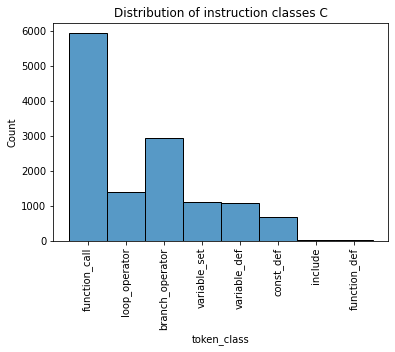

In [74]:
sns.histplot(cterr_df['token_class'])

plt.xticks(rotation=90)
plt.title('Distribution of instruction classes C')
plt.show()

In [75]:
cterr_df[cterr_df['token_class'] == 'function_call']

,original_id,changed_id,original_line,diff_op,changed_line,original_status,original_language,problem_id,language,filename_ext,token_class
0,s152683619,s597068013,13,c,13,Runtime Error,C,p00001,C,c,function_call
1,s044221442,s839825860,17,d,16,Wrong Answer,C,p00001,C,c,function_call
4,s348894386,s826240749,23,c,23,Wrong Answer,C,p00001,C,c,function_call
7,s294936892,s377408965,6,d,5,Wrong Answer,C,p00001,C,c,function_call
10,s556186742,s173380673,21,c,21,Wrong Answer,C,p00001,C,c,function_call
...,...,...,...,...,...,...,...,...,...,...,...
78107,s903610533,s620609611,10,c,10,WA: Presentation Error,C,p02467,C,c,function_call
78111,s622598348,s994072563,6,c,6,WA: Presentation Error,C,p02467,C,c,function_call
78212,s943920634,s242754422,19,c,19,WA: Presentation Error,C,p02468,C,c,function_call
78214,s701303157,s025536809,21,c,21,WA: Presentation Error,C,p02468,C,c,function_call


In [76]:
fcall_df = cterr_df[cterr_df['token_class'] == 'function_call']
loop = tqdm(fcall_df.iterrows(), total=len(fcall_df))
function_names = []
for idx, (original_id, changed_id, original_line, diff_op, changed_line, 
          _, _, problem_id, language, filename_ext, _) in loop:
    
    token_df = tokens_dfs[idx]
    
    tokens = token_df[['class_x', 'token_x']].dropna().values.tolist()
    if not tokens:
        tokens = token_df[['class_y', 'token_y']].dropna().values.tolist()
        
    function_name = tokens[0][1]
    function_names.append(function_name)
    
function_names = Counter(function_names)
function_names_df = pd.DataFrame.from_dict(function_names, orient='index', columns=['Count'])

100%|███████████████████████████████████████████████████| 5930/5930 [00:09<00:00, 635.55it/s]


In [77]:
function_names_df = function_names_df.sort_values('Count', ascending=False)
function_names_df.head(20)

,Count
printf,5054
scanf,556
puts,82
putchar,45
push,22
exit,21
fgets,17
main,12
free,8
memset,8


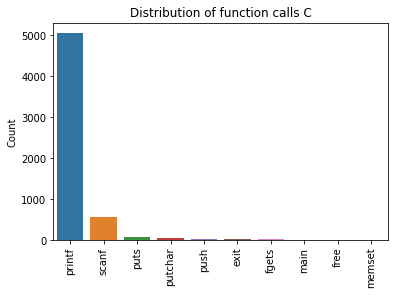

In [78]:
sns.barplot(x=function_names_df.index[:10], y=function_names_df['Count'][:10])

plt.xticks(rotation=90)
plt.title('Distribution of function calls C')
plt.show()